# Credit Card fraud detection


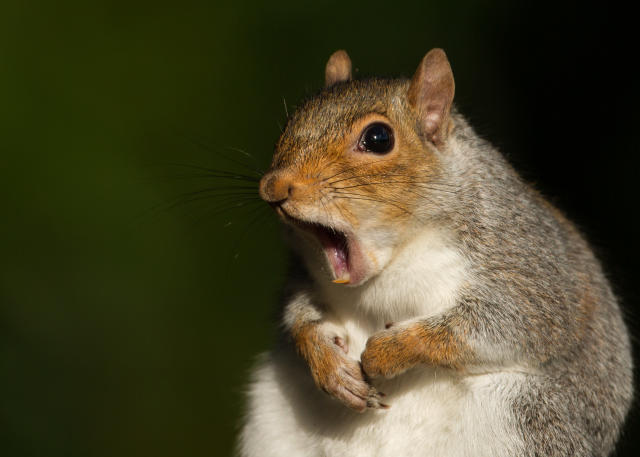  
This is the poor fellow's reaction after someone stole his card and traded 500 nuts from his account for a new phone.

* In this project we use data from previously labeled data from of credit card transactions that indicate wether it's a fraudlent transaction or not.  
* For privacy and since the data is real we only have 28 principle components,we don't know how many variables are there in the original data.  
* We will go through dealing with imbalanced data, feature selection, modeling, and evaluation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
df = pd.read_csv("Data/creditcard.csv")
df.head()

31 Features is a lot and as mentioned before Time and amount were not scaled before hand

In [8]:
print(df.shape)
print(df.info())

(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 2

All  data are numeric and we don't have any missing values.  
Let's check for possible duplicates as they pose the risk of overfitting the model due to redundunt information

In [10]:
df.duplicated().sum()

1081

Looks like we have some duplicate data. Those can lead to overfitting the model due and biasing it toward these observations. They also give the model a false sense of confidence as these data can lead the model to fitting more near them as it will believe these observations represent the real distribution which is not true. Also they skew the probability distribution so statistical methods ,especially those that rely on maximum likelyhood estimation, will either not give a good fit  or a false one.  

So let's drop them.

In [12]:
df.drop_duplicates(inplace = True)

In [13]:
df.reset_index(drop=True,inplace = True)

Now we don't have duplicates or missing values.  
We don't have categorical variables so there is no inspection needed here.  

Let's explore the only variable we really know.

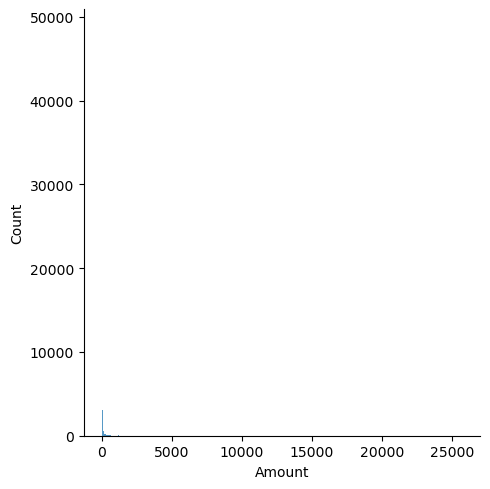

In [16]:
sns.displot(df['Amount'])

Notice something unusual? The axis actually give it away. Having a count that goes to 50 thousand and no column is visible then the bin is too small. Why? this is due to outliers. We have like 1% of the data more than 5000 and the summary statistics show this.

In [18]:
print(df['Amount'].describe())

count    283726.000000
mean         88.472687
std         250.399437
min           0.000000
25%           5.600000
50%          22.000000
75%          77.510000
max       25691.160000
Name: Amount, dtype: float64


we have a huge outlier so lets check other quantiles. so 99.8 percentile is 2200 still the remaining the observations are large in quantity.  
Here we used quantiles as they are unbiased estimators for location. They give us more of a reality check

In [20]:
df['Amount'].quantile(.998)

2200.7864999999833

99.9% of the values are less than 3005. so let's check this .1%

In [22]:
df[df['Amount']>2200]['Amount'].describe()

count      568.000000
mean      3528.718785
std       1928.221049
min       2201.430000
25%       2540.247500
50%       3008.640000
75%       3821.092500
max      25691.160000
Name: Amount, dtype: float64

this .1% is 284 rows. We still have this huge outlier among them.  
Let's see if we have frauds there. (I REALLY HOPE WE DON'T)

In [24]:
Counter(df[df['Amount']>2200]['Class'])

Counter({0: 568})

We have no fraudlent cases here. These outliers are so likely to skew our model so let's drop them

In [26]:
df2 = df[df['Amount']<2200].copy()

One thing to check is if we have induced lost the general imbalance in this tail. We can verify this using the box-plot

<Axes: ylabel='Amount'>

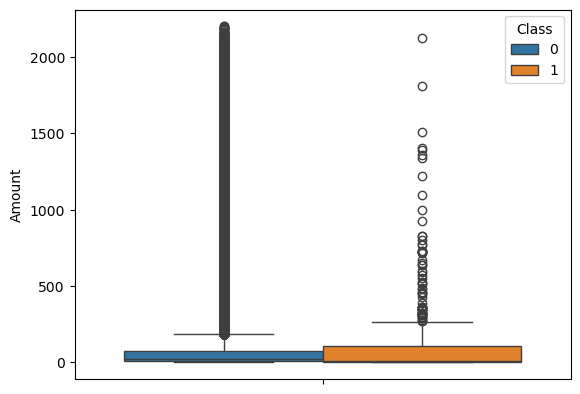

In [28]:
sns.boxplot(y=df2['Amount'],hue = df2['Class'])

This boxplot assures us that the imbalance still remains intact after removing some rows.

#### Feature selection

In [31]:
X =df2.drop('Class',axis=1).copy()
y= df2['Class'].copy()

We use point bisereal correlation coeffecient because we are trying to get the correlation of a continous variable with a binary one. We will also use kendall's ranking correlation coeffecient

In [33]:
from scipy.stats import pointbiserialr
pbs = []
for col in df.columns[:-1]:
    correlation_coefficient, p_value = pointbiserialr(df[col], df['Class'])
    pbs.append(correlation_coefficient)
pbs = np.array(pbs)

In [34]:
pbs

array([-0.01235934, -0.09448583,  0.08462445, -0.18232225,  0.12932583,
       -0.08781244, -0.04391541, -0.17234653,  0.03306802, -0.09402129,
       -0.20697124,  0.1490671 , -0.25071118, -0.00389696, -0.29337538,
       -0.00329956, -0.18718605, -0.31349827, -0.10533972,  0.03363115,
        0.02148634,  0.02635744,  0.00488723, -0.00633321, -0.00721013,
        0.00320249,  0.00426458,  0.02189211,  0.00968243,  0.00577702])

In [35]:
pd.DataFrame(np.round(pbs,3).reshape(1,-1),columns=X.columns).T[0].sort_values(ascending = False)[:4]

V11    0.149
V4     0.129
V2     0.085
V19    0.034
Name: 0, dtype: float64

Also we try using F-Test to gauge the feature usefulness in prediction of the binary variable

In [37]:
from sklearn.feature_selection import f_classif
f_statistic, p_values = f_classif(X, y)
np.round(p_values,5)

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.03898,
       0.     , 0.08119, 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.01075, 0.0001 , 0.00013, 0.09412, 0.02375, 0.     ,
       0.     , 0.     ])

In [38]:
pd.DataFrame(np.round(np.array(p_values),3).reshape(1,-1),columns = X.columns.values).T[0].sort_values(ascending = False)[:3]

V25    0.094
V15    0.081
V13    0.039
Name: 0, dtype: float64

We now do kendall's correlation which is another way to measure the correlation

In [40]:
corr_class = df.corr(method = 'kendall')['Class']

In [41]:
np.abs(corr_class).sort_values(ascending = False)[1:4]

V14    0.051595
V4     0.050339
V12    0.050132
Name: Class, dtype: float64

In [42]:
pbs_res = pd.DataFrame(np.round(pbs,3).reshape(1,-1),columns=X.columns).T[0].sort_values(ascending = False)[:4].index
anova_res= pd.DataFrame(np.round(np.array(p_values),3).reshape(1,-1),columns = X.columns.values).T[0].sort_values(ascending = False)[:3].index
kendall_res = np.abs(corr_class).sort_values(ascending = False)[1:4].index

We summarise the result of the previous filter methods using the union function. We are left with 9 features which can be later filtered more

In [44]:
filtered_cols = pbs_res.union(kendall_res).union(anova_res).values
print("We are left with:",len(filtered_cols),f'\nThe features are:\n{filtered_cols}')

We are left with: 9 
The features are:
['V11' 'V12' 'V13' 'V14' 'V15' 'V19' 'V2' 'V25' 'V4']


* *Feature selection is somewhat useless and meaningless because the features we have are PCA components*  
* Although an interesting insight is that components that explain less variance of the dataset are more related to the binary usefull.  
* This means that there was features in the original dataset that constituted most of the variance but they were still useless and should have been eleminated.

* We will pick two random features for visualization and they will be used later for reference during resampling.  
* I just thought this might be a good idea to think about what happens to the data and weather it was usefull or haarmful.  
* Again unfortunately due to having the **projected** data we will have to make do with what we have and just pick features that won't capture too much variance just for visualization.

In [48]:
df2['Class'].value_counts()

Class
0    282684
1       473
Name: count, dtype: int64

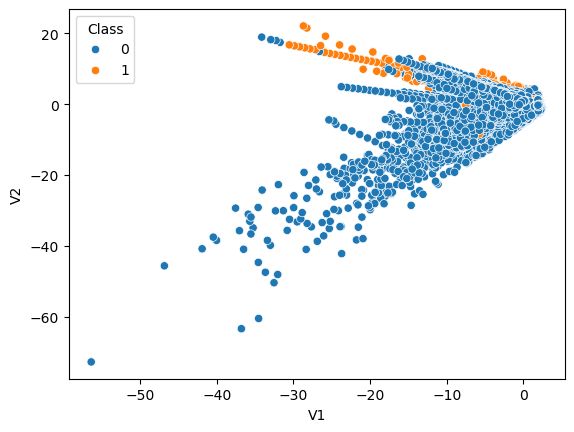

In [49]:
sns.scatterplot(x='V1',y='V2',data= df,hue = 'Class');

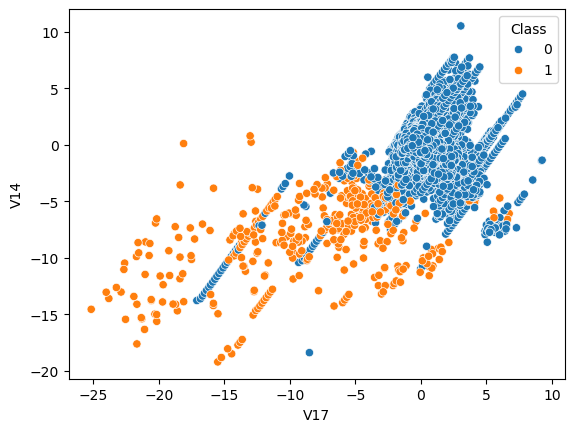

In [50]:
sns.scatterplot(x='V17',y='V14',data= df,hue = 'Class');

* We chose 17 and 18 because they don't explain too much or too little variance, this will make the graph readable
* Classes are not linearly separable and spread. This will be important in thinking about handling the data imbalance. Those two graphs will be taken as a reference.  
* One more takeaway is that for some variables it looks like we have somewhat of a distinction and some values appear to have a more fraudlent probability. When we start oversampling and undersampling we would like to keep the overlap and be sure not to remove data with high density of majority classes around it while also maintaining the over all structure of the data.

### Scaling Data

We have to scale the data before proceeding. This is important for SMOTE techniques since they rely on distance caluclations. So leaving time and amount with their scales will just let them dominate the distance metrics

In [54]:
from sklearn.preprocessing import StandardScaler
X =df2.drop('Class',axis=1).copy()
y= df2['Class'].copy()
scaler = StandardScaler()
scaler.set_output(transform = 'pandas')
X[['Amount','Time']]= scaler.fit_transform(X[['Amount','Time']])

### Handling data imbalance

When dealing with this kind of data we need creative and hybrid approaches.  

over sampling techniques like SMOTE are not so likely to create unrealistic values especially in time and amount so it is safe here. We also expect undersampling techniques like tomek linksto perform poorely here due to having small number of frauds and the overlapping of classes.  

Several approaches comes to mind but the one I want to try is oversampling the data by a small amount then under sampling using algorithms like near miss and tomek links. 

#### Oversampling
We will start by oversampling. We will use the methods imblearn provides which are mostly variants of SMOTE.  
Due to the big overlap between classes we expect to go for something that takes into account either the distribution of the data or the neighbouring data. We are mostly interested in capturing data that appears to be normal but is fraudlent.  
We start intializing the 3 candidate oversamplers

In [58]:
from imblearn.over_sampling import ADASYN,BorderlineSMOTE,KMeansSMOTE,SVMSMOTE,SMOTE
sm_re = SMOTE(sampling_strategy =0.003)
bls_re = BorderlineSMOTE(sampling_strategy =0.003, m_neighbors = 3, k_neighbors = 3) #fraud/non-fraud 
ada_re = ADASYN(sampling_strategy =0.003,n_neighbors=3)

Here we are making a color paletter that gives very high transparency to non-fraud class so we can see what is happening before and after oversampling.  
we also define a function to plot before and after images of the data from v17 and v14 columns

In [60]:
import colorsys
def hsl_to_rgba(h, s, l, alpha=1.0):
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, alpha)
hsl_colors = {0: (0.0, 0.7, 0.5, 0.1), 1: (0.6, 0.7, 0.5, 1)}  # Example HSL values with alpha

# Convert HSL to RGBA
palette = {k: hsl_to_rgba(*v) for k, v in hsl_colors.items()}

def plot_before_after(X_before,X_after,y_before,y_after,method):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    sns.scatterplot(data=X, x='V17', y='V14', hue=y, ax=ax1,palette=palette)
    ax1.set_title(f'Before {method}')
    
    sns.scatterplot(data=X_sm, x='V17', y='V14', hue=y_sm, ax=ax2,palette=palette)
    ax2.set_title(f'After {method}')
    plt.show()

SMOTE

In [62]:
X_sm,y_sm = sm_re.fit_resample(X,y)

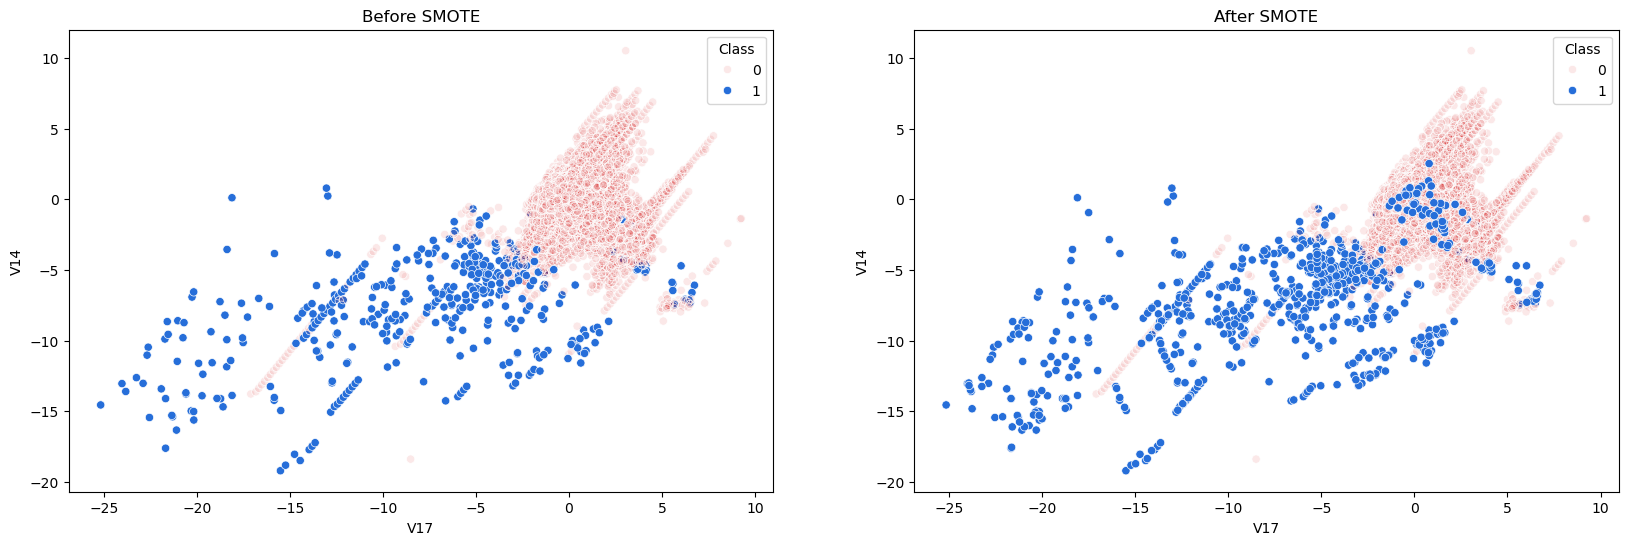

In [78]:
plot_before_after(X,X_sm,y,y_sm,sm_re.__class__.__name__)

SMOTE did well oversampling the data but it seems but for the right side we see it produced data that is supposed to be too rares and for the dense areas it appears to have made it denser but also filled gaps which make the data too synthetic

ADASYN

In [66]:
X_ada,y_ada = ada_re.fit_resample(X,y)

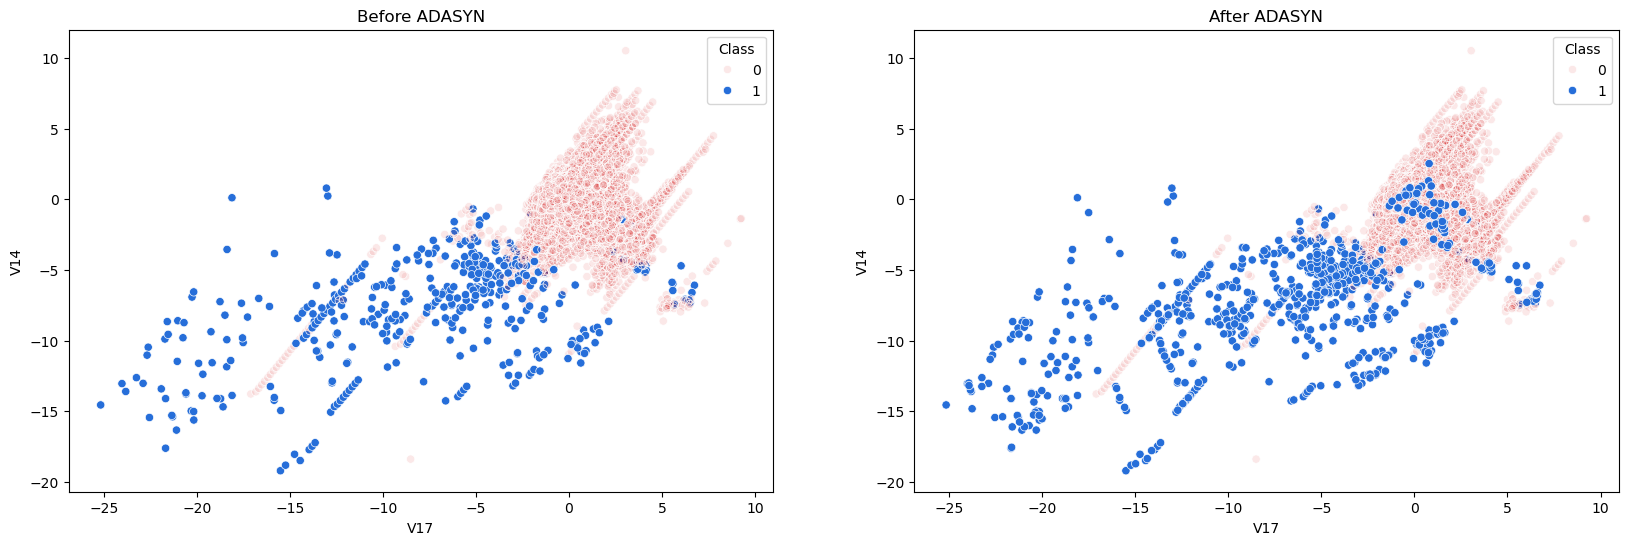

In [80]:
plot_before_after(X,X_ada,y,y_ada,ada_re.__class__.__name__)

Adasyn has focused too much on the distribution and appears to have produced a wider range of values than SMOTE but this filled in areas which we can't visually say if they are more likely to be fraud or not. especially in the center.

Borderline SMOTE

In [82]:
X_bls, y_bls =bls_re.fit_resample(X,y)

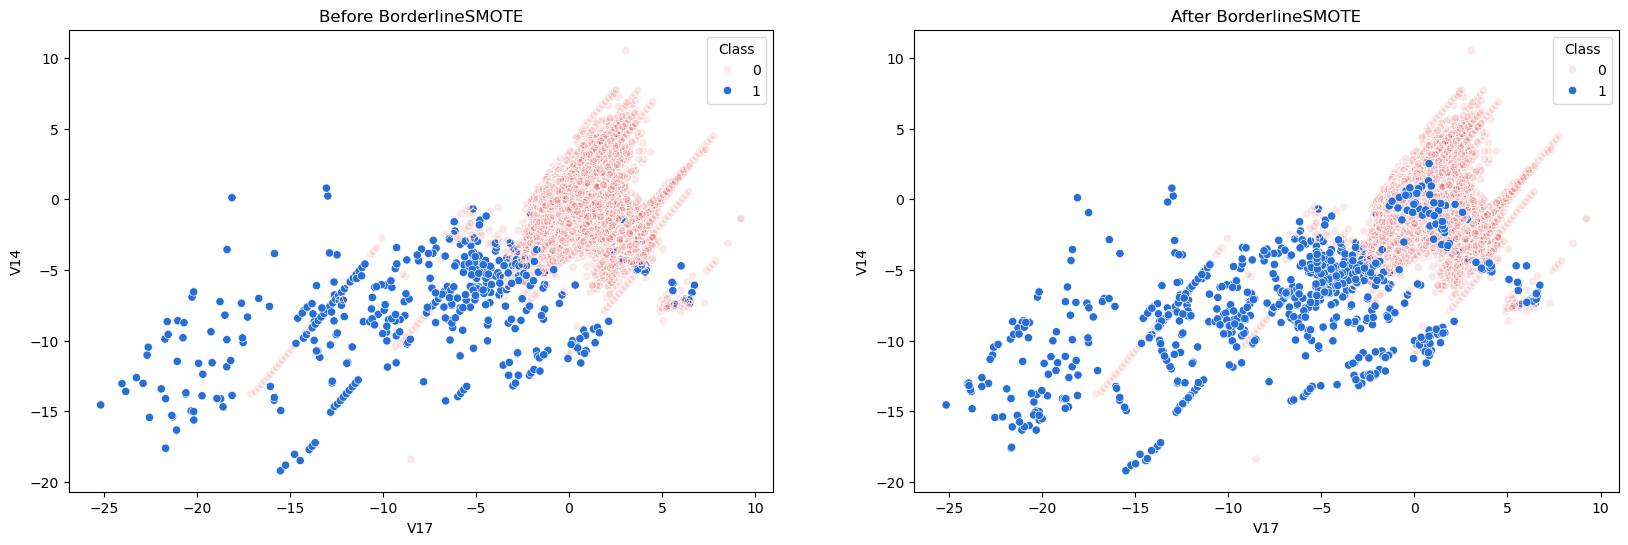

In [83]:
plot_before_after(X,X_bls,y,y_bls,bls_re.__class__.__name__)

BorderlineSMOTE has created some more samples on the left side which is really somewhat natural. The right side also somewhat has too synthetic data but is hasn't prouced much there so we might let it off the hook here.  

##### Under sampling

In [86]:
hsl_colors = {0: (0.0, 0.7, 0.5, 0.8), 1: (0.6, 0.7, 0.5, 1)}  # Example HSL values with alpha

# Convert HSL to RGBA
palette = {k: hsl_to_rgba(*v) for k, v in hsl_colors.items()}

In [87]:
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(sampling_strategy = 0.02,version = 2,n_neighbors =1 ,n_jobs = -1)

In [88]:
X_bls_nm1, y_bls_nm1 = nm1.fit_resample(X_sm, y_sm)

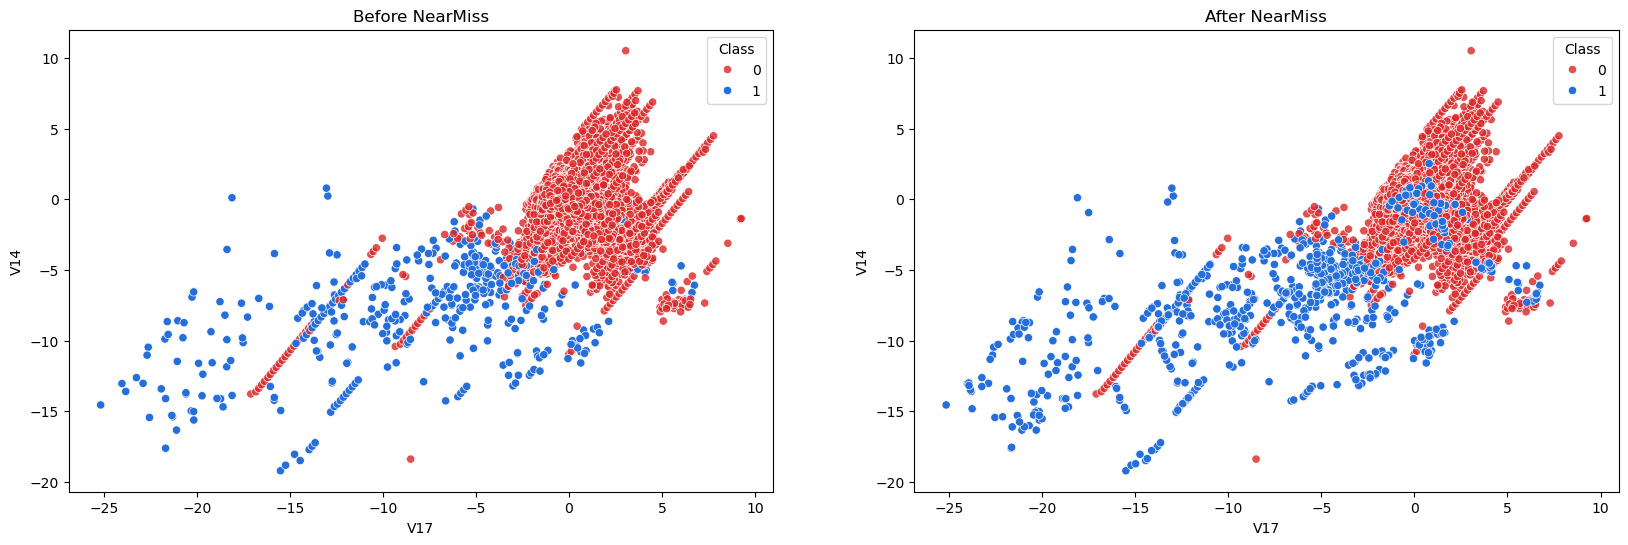

In [89]:
plot_before_after(X,X_bls_nm1,y,y_bls_nm1,nm1.__class__.__name__)

NearMiss 1 has left some of the left values well but also didn't eleminate much from right side. We will use this

Not all handling is done in the data so lets go to the next step
### Modeling

First and foremost we need to split the data into testing and training data to evaluate our models.

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score,confusion_matrix, classification_report
X_train, X_test, y_train, y_test = train_test_split(X_bls_nm1,y_bls_nm1,test_size = 0.2,random_state= 42)

* When dealing with severly imbalanced data we have to take care during modeling.  
* We use algorithms that can deal with imbalanced data like bagging and boosting. Although we expect Boosting algorithms to be superior due to weighting missclassified data more. 
* We also, utilize sample weighting to help the model tilt more toward the minority class
* In case of fraud detection we have False Negatives being too crucial and we wish for them to be zero really
* False Positives can be annoying too really but it is less costly as it can be simply handled by something like two step verification or manual intervention from the credit card holder

In [95]:
# Initialize an empty DataFrame with the desired columns
scores_df = pd.DataFrame(columns=['model', 'precision', 'recall', 'f1'])

We define a function to one-line training and evaluating

In [97]:
def train_evaluate(model, df, plot=True, **kwargs):
    plt.figure(figsize=(4, 2))
    
    # Initialize and train the model
    model_instance = model(**kwargs)
    model_instance.fit(X_train, y_train)
    
    # Predict using the trained model
    y_pred = model_instance.predict(X_test)
    new_row = pd.DataFrame({
        'model': [model_instance.__class__.__name__],
        'f1': [f1_score(y_test, y_pred)],
        'precision': [precision_score(y_test, y_pred)],
        'recall': [recall_score(y_test, y_pred)]
    })
    
    df = pd.concat([df, new_row], ignore_index=True)
    print(classification_report(y_test,y_pred))
    # Plot confusion matrix if plot=True
    if plot:
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.show()
    
    return df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8471
           1       0.98      0.85      0.91       179

    accuracy                           1.00      8650
   macro avg       0.99      0.93      0.96      8650
weighted avg       1.00      1.00      1.00      8650



C:\Users\user\AppData\Local\Temp\ipykernel_13152\2121676910.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


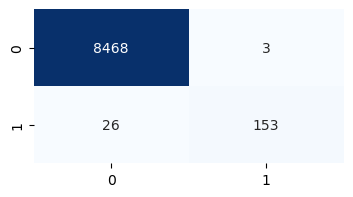

In [98]:
from sklearn.ensemble import RandomForestClassifier
scores_df = train_evaluate(RandomForestClassifier,df=scores_df,class_weight = 'balanced',n_jobs=-1)

For Random fores this is bad obviously and doesn't look promising to try and tune

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8471
           1       0.49      0.95      0.64       179

    accuracy                           0.98      8650
   macro avg       0.74      0.96      0.82      8650
weighted avg       0.99      0.98      0.98      8650



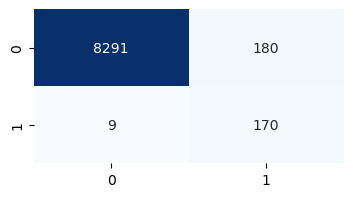

In [100]:
from sklearn.linear_model import LogisticRegression

scores_df =train_evaluate(LogisticRegression,df=scores_df,class_weight = 'balanced')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8471
           1       0.96      0.94      0.95       179

    accuracy                           1.00      8650
   macro avg       0.98      0.97      0.98      8650
weighted avg       1.00      1.00      1.00      8650



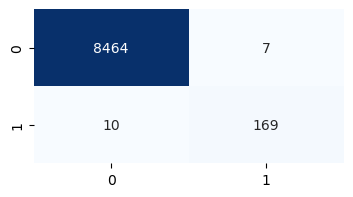

In [101]:
import xgboost as xgb
scores_df = train_evaluate(xgb.XGBClassifier,df=scores_df,scale_pos_weight = 30,grow_policy = 'depthwise',eta = 0.3)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8471
           1       0.88      0.87      0.87       179

    accuracy                           0.99      8650
   macro avg       0.94      0.93      0.94      8650
weighted avg       0.99      0.99      0.99      8650



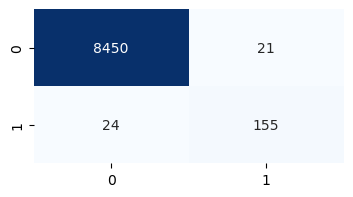

In [102]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

scores_df= train_evaluate(AdaBoostClassifier,df=scores_df,
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    algorithm = "SAMME",
    n_estimators = 500)

We see we have xgboost and logistic regression are both doing well but xgboost is best. Let's finetune it and try to get the best of it

### Fine Tuning
We will be using hyperopt to finetune our model. Although grid and random search might do well, bayesian optimization tend to achieve comparable or better results in less trials.  
We have to give it the black box function it will try to optimize which we name objective. We then make a tuning function that just takes the space specified, the model to be fine tuned, and a maximum number of trials.

In [105]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

def objective(params,model):
    clf = model(**params)
    clf.fit(X_train,y_train)
    y_pred= clf.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    return -f1
def tune_model(space,model, max_evals = 100):
    trials = Trials()
    best_hyperparams = fmin(fn = lambda space:objective(space,model),
                        space = space,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)
    return best_hyperparams,trials

We define quite a good space and we will see that in 150 trials we can achieve good improvement.  
We will only tune the xgboost model.

In [106]:
space = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 200, 600, 25)),
        'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
        'learning_rate': hp.uniform('learning_rate', 0.2, 0.4),
        'subsample': hp.uniform('subsample', 0.3, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'min_child_weight': scope.int(hp.quniform('min_child_weight', 1,10, 1)),
        'scale_pos_weight': hp.uniform('scale_pos_weight',1, 200)
    }

best_hyperparams_xgb ,trials_xgb= tune_model(space, xgb.XGBClassifier, max_evals = 150)

100%|█████████████████████████████████████████████| 150/150 [02:23<00:00,  1.05trial/s, best loss: -0.9719101123595506]


In [147]:
best_hyperparams_xgb

{'colsample_bytree': 0.5951362493214352,
 'gamma': 0.02661643854998097,
 'learning_rate': 0.253109814531323,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 425,
 'scale_pos_weight': 35.61780658820709,
 'subsample': 0.9862228755237377}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8471
           1       0.98      0.97      0.97       179

    accuracy                           1.00      8650
   macro avg       0.99      0.98      0.99      8650
weighted avg       1.00      1.00      1.00      8650



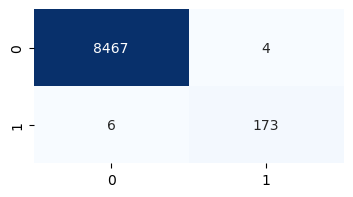

In [165]:
best_hyperparams_xgb['n_estimators'] = int(best_hyperparams_xgb['n_estimators'])
best_hyperparams_xgb['max_depth'] = int(best_hyperparams_xgb['max_depth'])
best_hyperparams_xgb['min_child_weight'] = int(best_hyperparams_xgb['min_child_weight'])
scores_df = train_evaluate(xgb.XGBClassifier,df = scores_df, **best_hyperparams_xgb)

In [167]:
# rename the model in the dataframe entry for visualization
scores_df.iloc[-1,0] = f'{scores_df.iloc[-1,:]['model']} tuned'

*We summarise the models performance as follows*

Text(0.5, 0, '')

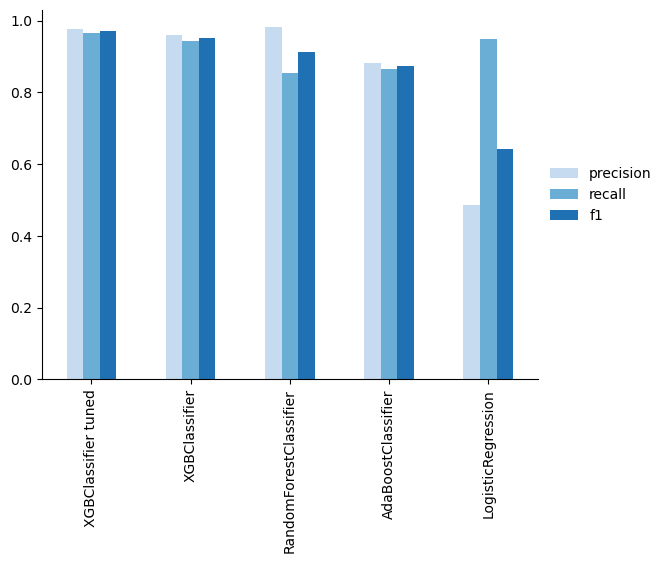

In [171]:
ax = scores_df.sort_values(by = ['f1','recall','precision'],ascending = False).plot(x= 'model',kind = 'bar',color =sns.color_palette("Blues",3))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
